In [130]:
import sys
from pathlib import Path
import pandas as pd

# Handle paths for Jupyter (where __file__ is not defined)
try:
    current_path = Path(__file__).resolve()
except NameError:
    # __file__ is not defined in Jupyter; use cwd as fallback
    current_path = Path.cwd()

# Set up project paths
project_root = current_path.parents[1] if len(current_path.parents) >= 3 else current_path
local_path = project_root / 'back_end'

# Add project paths to sys.path if not already present
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))
if str(local_path) not in sys.path:
    sys.path.insert(0, str(local_path))

# Import project modules (will work if path is correct)
import src.utils.utils
import src.utils.logging_utils
import src.main as main
from src.plotting import *
import src.data_cleaning as data_cleaning
import src.all_linkages as linkages


multimer_size = 5
# Function to load data
def download_data_dict(multimer_size):
    input_dir = project_root / 'back_end' / 'data' / 'filtered_reaction_database' / f'multimer_size_{multimer_size}'
    combined_database = pd.read_csv(input_dir / 'combined_database.csv', index_col=0)
    context_history = pd.read_csv(input_dir / 'context_history.csv', index_col=0)
    donor_history = pd.read_csv(input_dir / 'donor_history.csv', index_col=0)
    reaction_history = pd.read_csv(input_dir / 'reaction_history.csv', index_col=0)
    ubiquitin_history = pd.read_csv(input_dir / 'ubiquitin_history.csv', index_col=0)
    return {
        'combined_database': combined_database,
        'context_history': context_history,
        'donor_history': donor_history,
        'reaction_history': reaction_history,
        'ubiquitin_history': ubiquitin_history
    }

# Load the data
data_dict = download_data_dict(multimer_size)
combined_database = data_dict['combined_database']
context_history = data_dict['context_history']
donor_history = data_dict['donor_history']
reaction_history = data_dict['reaction_history']
ubiquitin_history = data_dict['ubiquitin_history']

# Function to load data
def download__all_data_dict(multimer_size):
    input_dir = project_root / 'back_end' / 'data' / 'reaction_database' / f'multimer_size_{multimer_size}'
    context_history = pd.read_csv(input_dir / 'context_history.csv', index_col=0)
    donor_history = pd.read_csv(input_dir / 'donor_history.csv', index_col=0)
    reaction_history = pd.read_csv(input_dir / 'reaction_history.csv', index_col=0)
    ubiquitin_history = pd.read_csv(input_dir / 'ubiquitin_history.csv', index_col=0)
    return {
        'context_history': context_history,
        'donor_history': donor_history,
        'reaction_history': reaction_history,
        'ubiquitin_history': ubiquitin_history
    }

# Load the data
data_dict = download__all_data_dict(multimer_size)
all_context_history = data_dict['context_history']
all_donor_history = data_dict['donor_history']
all_reaction_history = data_dict['reaction_history']
all_ubiquitin_history = data_dict['ubiquitin_history']

import json

# Replace with the actual path to your file
file_path = f"/Users/ekummelstedt/le_code_base/ubiquitinformatics/front_end/src/data/multimer_id_to_json{multimer_size}.json"

# Open and read the JSON file
with open(file_path, 'r') as f:
    multimers = json.load(f)

In [131]:
def reaction_path_statistics(_ubiquitin_history_, _context_history_, multimers, project_root, multimer_size):
    
    # Reveal all the edges for trimers 
    def reveal_edges(context_):
        """
        Gives the ID of the linkages from the context.
        """
        edges = context_['conjugated_lysines']
        return edges


    # Reset index if needed
    _ubiquitin_history_ = _ubiquitin_history_.reset_index()
    _context_history_ = _context_history_.reset_index()

    # This should be a separate function in run_file.pyxs
    multimered_ubiquitin_history, multimered_context_history = data_cleaning.global_deprotection_dual(_ubiquitin_history_, _context_history_)

    json_counting = {}

    for i in range(len(multimers.keys())):
        num_of_reactions = len(multimered_ubiquitin_history[multimered_ubiquitin_history['final_multimer'] == multimers[f'Ub{multimer_size}_{i+1}']])
        ubi_DAG, ubi_context = main.iterate_through_ubiquitin(multimers[f'Ub{multimer_size}_{i+1}'])
        json_counting[f'Ub{multimer_size}_{i+1}'] = {
            num_of_reactions: 'num_of_reactions', 
            'ubiDAG_edges': str(reveal_edges(ubi_context))
            }

    # Load the data
    higher_level_data = linkages.load_multimer_contexts(project_root, multimer_size)
    n_level_data = linkages.load_multimer_contexts(project_root, 3)

    # Filter by lysine types
    higher_level_dict = linkages.get_multimer_edges_by_lysines(higher_level_data, {"K48", "K63"})
    n_level_dict = linkages.get_multimer_edges_by_lysines(n_level_data, {"K48", "K63"})

    # Analyze subgraph containment, with K48 and K63 linkages
    results = linkages.analyze_subgraph_containment(higher_level_dict, n_level_dict)


    def simplify_linkage_dict(nested_dict):
        """
        Simplifies the nested dictionary by removing specific keys and counting heterotypic and branching linkages.
        Only works with K48 and K63 linkages when n_level_data = linkages.load_multimer_contexts(project_root, 3) is set to 3.

        Args:
            nested_dict (dict): The nested dictionary to simplify.
        Returns:
            dict: A simplified dictionary with counts of heterotypic and branching linkages.
        """
        
        result = {}

        # Keys to be removed
        keys_to_remove = [
            "[[1, 'K63', 2], [2, 'K63', 3]]",
            "[[1, 'K48', 2], [2, 'K48', 3]]"
        ]

        # Keys to count for heterotypic and branching
        heterotypic_keys = [
            "[[1, 'K63', 2], [2, 'K48', 3]]",
            "[[1, 'K48', 2], [2, 'K63', 3]]"
        ]
        branching_key = "[[1, 'K63', 2], [1, 'K48', 3]]"

        for outer_key, inner_dict in nested_dict.items():
            heterotypic_total = 0
            branching_total = 0
            simplified_inner = {}

            for k, v in inner_dict.items():
                if k in keys_to_remove:
                    continue
                elif k in heterotypic_keys:
                    heterotypic_total += v
                elif k == branching_key:
                    branching_total += v
                else:
                    simplified_inner[k] = v

            # Always include the linkage counts, even if they are 0
            simplified_inner['heterotypic_linkage'] = heterotypic_total
            simplified_inner['branching_linkage'] = branching_total

            result[outer_key] = simplified_inner

        return result

    # Simplify the linkage dictionary
    simplified_example = simplify_linkage_dict(results)

    # Convert the nested dictionary into a flat structure suitable for a DataFrame
    json_with_reaction_information = {}
    for key, value in json_counting.items():
        json_with_reaction_information[f'{key}'] = {
            'UbID': key,
            'num_of_reactions': list(value.keys())[0],
            'ubiDAG_edges': value['ubiDAG_edges'],
            'heterotypic_linkage': simplified_example.get(value['ubiDAG_edges'])['heterotypic_linkage'],
            'branching_linkage': simplified_example.get(value['ubiDAG_edges'])['branching_linkage']
            }

    return json_with_reaction_information

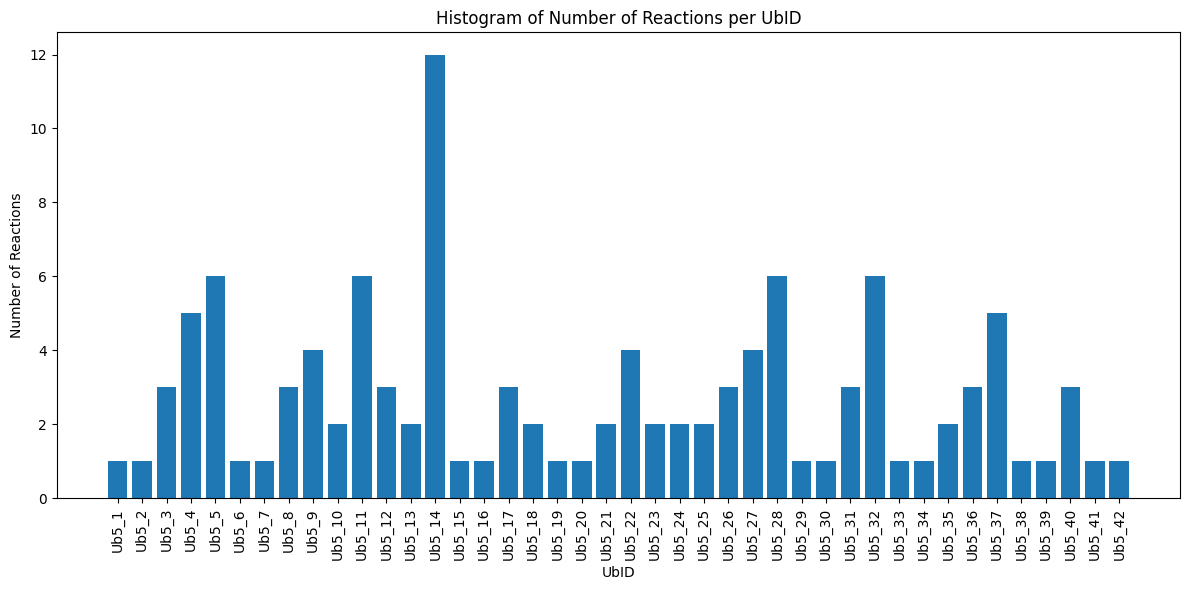

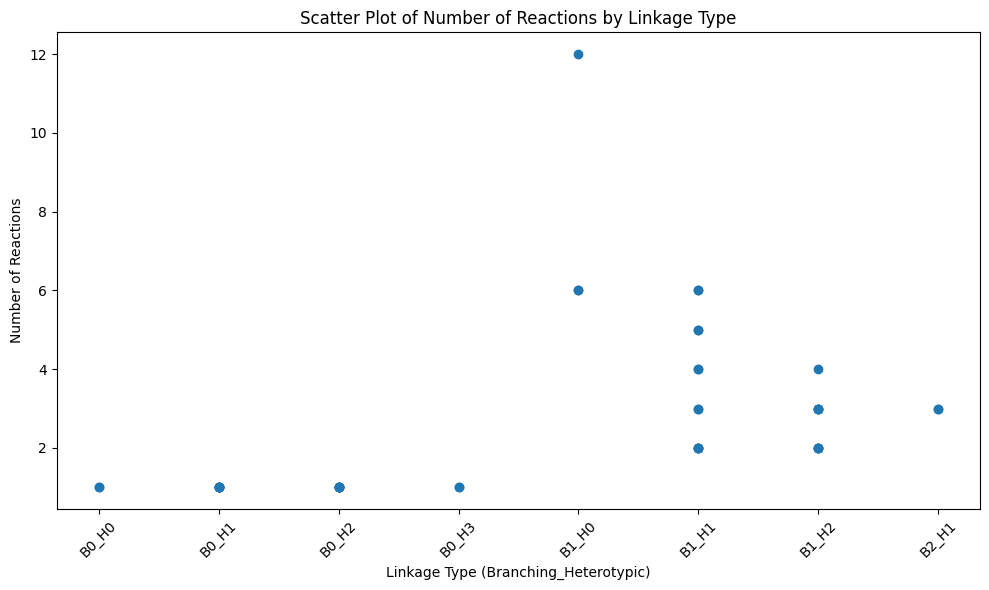

In [132]:
flattened_data = reaction_path_statistics(ubiquitin_history, context_history, multimers, project_root, multimer_size)
# Convert to DataFrame
df = pd.DataFrame(flattened_data).T

# First plot: Histogram
plt.figure(figsize=(12, 6))
plt.bar(df['UbID'], df['num_of_reactions'])
plt.xlabel('UbID')
plt.ylabel('Number of Reactions')
plt.title('Histogram of Number of Reactions per UbID')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Second plot: Scatter plot
def plot_scatter_by_linkage(df):
    df_sorted = df.sort_values(by=['branching_linkage', 'heterotypic_linkage'])
    x_labels = [f"B{b}_H{h}" for b, h in zip(df_sorted['branching_linkage'], df_sorted['heterotypic_linkage'])]
    
    plt.figure(figsize=(10, 6))
    plt.scatter(x_labels, df_sorted['num_of_reactions'])
    plt.xlabel('Linkage Type (Branching_Heterotypic)')
    plt.ylabel('Number of Reactions')
    plt.title('Scatter Plot of Number of Reactions by Linkage Type')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

plot_scatter_by_linkage(df)